google/vivit-b-16x2 <br>
https://huggingface.co/google/vivit-b-16x2 <br>
https://huggingface.co/docs/transformers/main/model_doc/vivit

# Import Library

In [1]:
!pip uninstall -y tensorflow

Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0


In [2]:
import torch
torch.autograd.set_detect_anomaly(True)

print('pytorch version', torch.__version__)
print("GPU available:", torch.cuda.device_count())
#print('GPU name:',torch.cuda.get_device_name(0))

# Set the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pytorch version 2.5.1+cu124
GPU available: 1


In [3]:
#!nvcc --version

In [4]:
# For data augmentation
from torchvision import transforms

In [5]:
#!pip install -q transformers==4.35.0

In [6]:
import transformers

# For Tokenizers
from transformers import VivitImageProcessor, VivitConfig

# For Model
from transformers import VivitModel, VivitForVideoClassification

# For TPU
from transformers import set_seed
from torch.optim import AdamW

In [7]:
!pip install -q datasets #==2.10.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.7 MB/s eta 0:00:00


In [8]:
# For Data Loaders
import datasets
from torch.utils.data import Dataset, DataLoader
#from torchvision.transforms import Compose, Resize, ToTensor

In [9]:
#!pip install -q accelerate==0.21.0

In [10]:
# For Display
from tqdm.notebook import tqdm

# For GPU
from accelerate import Accelerator, notebook_launcher

In [11]:
!pip install -q decord

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 111.5 MB/s eta 0:00:00


In [12]:
# Use PyTorch bridge for Decord
import decord

from decord.bridge import set_bridge
decord.bridge.set_bridge("torch")

from decord import VideoReader

In [13]:
#!pip install -q av

In [14]:
#import kagglehub
import random

import cv2
from google.colab.patches import cv2_imshow

import os
import PIL
import gc
from glob import glob
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8,5]

In [15]:
import torch.nn.functional as F
from torch.nn import Linear, Softmax, CrossEntropyLoss, ReLU, Flatten, Sequential

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [17]:
# installing MediaPipe
!pip install -q mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 58.9 MB/s eta 0:00:00


In [18]:
#pose_landmark_model = !wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task
#hand_landmark_model = !wget -q https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task

In [19]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2

In [20]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands
mp_face = mp.solutions.face_mesh
mp_pose = mp.solutions.pose
mp_holistic = mp.solutions.holistic

# Initialse Globle Variables

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
from google.colab import userdata
secret_token_hf = userdata.get('HF_TOKEN')

In [23]:
gdrive_path = '/content/drive/MyDrive/Kaggle/SignLanguage'
local_path = '/content/SignLanguage'

In [39]:
BATCH_SIZE = 2
print('BATCH_SIZE =',BATCH_SIZE)

MODEL_TRANSFORMER = 'google/vivit-b-16x2' # google/vivit-b-16x2-kinetics400

CLIP_LENGTH = 32 # MTech project was with CLIP_LENGTH = 85, CLIP_LENGTH of model = 32
print('Number of Frames =',CLIP_LENGTH)

CLIP_SIZE = 224
print('Image Dimension =', CLIP_SIZE,'X', CLIP_SIZE)

BATCH_SIZE = 2
Number of Frames = 32
Image Dimension = 224 X 224


In [25]:
#import os
#os.environ["CUDA_MODULE_LOADING"] = "LAZY"

In [26]:
def seed_everything(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [27]:
seed_everything(42)

# Import Data

In [28]:
data_dir = f'{gdrive_path}/ProcessedData_vivit'
print(data_dir)

/content/drive/MyDrive/Kaggle/SignLanguage/ProcessedData_vivit


In [29]:
# Copy videos from Google Drive to local disk for faster loading during training
if not os.path.exists(local_path):
    shutil.copytree(data_dir, local_path)

print("Videos copied to local disk.")

Videos copied to local disk.


In [30]:
print(local_path)

/content/SignLanguage


In [31]:
classes = sorted(os.listdir(local_path))
print(classes)

['afternoon', 'animal', 'bad', 'beautiful', 'big', 'bird', 'blind', 'cat', 'cheap', 'clothing', 'cold', 'cow', 'curved', 'deaf', 'dog', 'dress', 'dry', 'evening', 'expensive', 'famous', 'fast', 'female', 'fish', 'flat', 'friday', 'good', 'happy', 'hat', 'healthy', 'horse', 'hot', 'hour', 'light', 'long', 'loose', 'loud', 'minute', 'monday', 'month', 'morning', 'mouse', 'narrow', 'new', 'night', 'old', 'pant', 'pocket', 'quiet', 'sad', 'saturday', 'second', 'shirt', 'shoes', 'short', 'sick', 'skirt', 'slow', 'small', 'suit', 'sunday', 't_shirt', 'tall', 'thursday', 'time', 'today', 'tomorrow', 'tuesday', 'ugly', 'warm', 'wednesday', 'week', 'wet', 'wide', 'year', 'yesterday', 'young']


In [32]:
label_to_idx = {}
idx_to_label = {}

for idx, label in enumerate(classes):
  class_folder = os.path.join(local_path, label)
  if os.path.exists(data_dir):
    label_to_idx[label] = idx
    idx_to_label[idx] = label

In [33]:
print(label_to_idx)

{'afternoon': 0, 'animal': 1, 'bad': 2, 'beautiful': 3, 'big': 4, 'bird': 5, 'blind': 6, 'cat': 7, 'cheap': 8, 'clothing': 9, 'cold': 10, 'cow': 11, 'curved': 12, 'deaf': 13, 'dog': 14, 'dress': 15, 'dry': 16, 'evening': 17, 'expensive': 18, 'famous': 19, 'fast': 20, 'female': 21, 'fish': 22, 'flat': 23, 'friday': 24, 'good': 25, 'happy': 26, 'hat': 27, 'healthy': 28, 'horse': 29, 'hot': 30, 'hour': 31, 'light': 32, 'long': 33, 'loose': 34, 'loud': 35, 'minute': 36, 'monday': 37, 'month': 38, 'morning': 39, 'mouse': 40, 'narrow': 41, 'new': 42, 'night': 43, 'old': 44, 'pant': 45, 'pocket': 46, 'quiet': 47, 'sad': 48, 'saturday': 49, 'second': 50, 'shirt': 51, 'shoes': 52, 'short': 53, 'sick': 54, 'skirt': 55, 'slow': 56, 'small': 57, 'suit': 58, 'sunday': 59, 't_shirt': 60, 'tall': 61, 'thursday': 62, 'time': 63, 'today': 64, 'tomorrow': 65, 'tuesday': 66, 'ugly': 67, 'warm': 68, 'wednesday': 69, 'week': 70, 'wet': 71, 'wide': 72, 'year': 73, 'yesterday': 74, 'young': 75}


In [34]:
print(idx_to_label)

{0: 'afternoon', 1: 'animal', 2: 'bad', 3: 'beautiful', 4: 'big', 5: 'bird', 6: 'blind', 7: 'cat', 8: 'cheap', 9: 'clothing', 10: 'cold', 11: 'cow', 12: 'curved', 13: 'deaf', 14: 'dog', 15: 'dress', 16: 'dry', 17: 'evening', 18: 'expensive', 19: 'famous', 20: 'fast', 21: 'female', 22: 'fish', 23: 'flat', 24: 'friday', 25: 'good', 26: 'happy', 27: 'hat', 28: 'healthy', 29: 'horse', 30: 'hot', 31: 'hour', 32: 'light', 33: 'long', 34: 'loose', 35: 'loud', 36: 'minute', 37: 'monday', 38: 'month', 39: 'morning', 40: 'mouse', 41: 'narrow', 42: 'new', 43: 'night', 44: 'old', 45: 'pant', 46: 'pocket', 47: 'quiet', 48: 'sad', 49: 'saturday', 50: 'second', 51: 'shirt', 52: 'shoes', 53: 'short', 54: 'sick', 55: 'skirt', 56: 'slow', 57: 'small', 58: 'suit', 59: 'sunday', 60: 't_shirt', 61: 'tall', 62: 'thursday', 63: 'time', 64: 'today', 65: 'tomorrow', 66: 'tuesday', 67: 'ugly', 68: 'warm', 69: 'wednesday', 70: 'week', 71: 'wet', 72: 'wide', 73: 'year', 74: 'yesterday', 75: 'young'}


In [35]:
# Collect all video files
video_path = []
labels_int = []
labels_text = []
for idx, label in enumerate(classes):
  class_folder = os.path.join(local_path, label)
  #print(class_folder)
  video_file = glob(os.path.join(class_folder, '*.MOV'))
  #print(video_file)
  video_path.extend(video_file)
  labels_int.extend([idx] * len(video_file))
  labels_text.extend([label] * len(video_file))

In [36]:
print('input path size:', len(video_path))
print(video_path)

input path size: 1166
['/content/SignLanguage/afternoon/MVI_5513.MOV', '/content/SignLanguage/afternoon/MVI_5063.MOV', '/content/SignLanguage/afternoon/MVI_4658.MOV', '/content/SignLanguage/afternoon/MVI_4656.MOV', '/content/SignLanguage/afternoon/MVI_5065.MOV', '/content/SignLanguage/afternoon/MVI_4655.MOV', '/content/SignLanguage/afternoon/MVI_5511.MOV', '/content/SignLanguage/afternoon/MVI_4657.MOV', '/content/SignLanguage/afternoon/MVI_5512.MOV', '/content/SignLanguage/afternoon/MVI_5514.MOV', '/content/SignLanguage/afternoon/MVI_5064.MOV', '/content/SignLanguage/animal/MVI_4168.MOV', '/content/SignLanguage/animal/MVI_3082.MOV', '/content/SignLanguage/animal/MVI_3084.MOV', '/content/SignLanguage/animal/MVI_3026.MOV', '/content/SignLanguage/animal/MVI_3027.MOV', '/content/SignLanguage/animal/MVI_3025.MOV', '/content/SignLanguage/animal/MVI_4169.MOV', '/content/SignLanguage/animal/MVI_3107.MOV', '/content/SignLanguage/animal/MVI_3109.MOV', '/content/SignLanguage/animal/MVI_3058.MOV',

In [37]:
print('labels size:', len(labels_int))
print(labels_int)

labels size: 1166
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 

In [38]:
print('labels size:', len(labels_text))
print(labels_text)

labels size: 1166
['afternoon', 'afternoon', 'afternoon', 'afternoon', 'afternoon', 'afternoon', 'afternoon', 'afternoon', 'afternoon', 'afternoon', 'afternoon', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'beautiful', 'beautiful', 'beautiful', 'beautiful', 'beautiful', 'beautiful', 'beautiful', 'beautiful', 'beautiful', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'blind', 'blind', 'blind', 'blind', 'blind', 'blind', 'blind', 'blind', 'cat', 'cat', 'cat', 'cat', 'ca

# Train Test Split

In [40]:
train_path, val_path, train_label, val_label = train_test_split(video_path, labels_int, test_size=0.2, stratify=labels_text, random_state=42)
train_path, test_path, train_label, test_label = train_test_split(train_path, train_label, test_size=0.2, stratify=train_label, random_state=42)

In [41]:
print('Train data size:',len(train_path))
print('Val data size:',len(val_path))
print('Test data size:',len(test_path))

Train data size: 745
Val data size: 234
Test data size: 187


In [42]:
train_label[:5]

[54, 28, 25, 52, 5]

# Validating the input data - NOT USED

In [ ]:
#idx = 2
#train_path[idx]

In [ ]:
#vr_demo = VideoReader(train_path[idx])#, width=CLIP_WIDTH, height=CLIP_HEIGHT)

In [ ]:
#print('Number of Fames in the video:',len(vr_demo))

In [ ]:
#frame = vr_demo[1]
#print('Shape of the frame:',frame.shape)

In [ ]:
#key_indices = vr_demo.get_key_indices()
#key_frames = vr_demo.get_batch(key_indices)
#print(key_frames.shape)

In [ ]:
#print(key_frames.permute(0, 3, 1, 2).shape)

In [ ]:
#image_processor_demo = VivitImageProcessor.from_pretrained(MODEL_TRANSFORMER,
#                                                           size={'width':CLIP_WIDTH, 'height':CLIP_HEIGHT},
#                                                           crop_size={'width':CLIP_WIDTH, 'height':CLIP_HEIGHT}
#                                                           )

In [ ]:
#model_inputs_demo = image_processor_demo.preprocess(videos=list(key_frames),
#                                               return_tensors='pt',
#                                               input_data_format='channels_last', # image in (height, width, num_channels) format.
#                                               )

In [ ]:
#print(model_inputs_demo.pixel_values.shape)

In [ ]:
#reshaped_video = model_inputs_demo.pixel_values[0].permute(0, 2, 3, 1)

In [ ]:
#plt.imshow(reshaped_video[0])

In [ ]:
#sample_input = model_inputs_demo.pixel_values[0]
#
## Define original dimensions
#height =  sample_input.shape[2]
#width = sample_input.shape[3]
#
## Define the crop factor
#target_height = height - (height // 10) # Crop 10% of the height
#target_width =  width - (width // 2) # Crop 50% of width
#
## Define (Offset) the amount of crop required at each side of the image
#offset_height = (height - target_height) // 2
#offset_width = (width - target_width) // 2

In [ ]:
#sample_out = transforms.v2.functional.crop(sample_input, offset_height, offset_width, target_height, target_width)

In [ ]:
#print(sample_input.shape)
#print(sample_out.shape)

In [ ]:
#reshaped_video = sample_out.permute(0, 2, 3, 1)

In [ ]:
#plt.imshow(reshaped_video[0])

In [ ]:
## Define a sample transformation pipeline
#transform_demo = transforms.Compose([
#    #transforms.RandomHorizontalFlip(),
#    #transforms.RandomVerticalFlip(),
#    #transforms.RandomResizedCrop(size=(640, 480), scale=(0.5, 1)),  # Zoom and crop # (1080, 1920)
#    transforms.v2.Resize((224, 224)),
#    transforms.v2.RandomPerspective(),
#    #transforms.v2.ColorJitter(brightness=(0.2, 0.8), contrast=(0.2, 0.8), saturation=(0.2, 0.8), hue=(-0.2, 0.2)),
#    transforms.v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
#    #transforms.v2.ColorJitter(),
#    #transforms.v2.RandomRotation(15),
#    #transforms.v2.ToImage(),
#    transforms.v2.ToDtype(torch.float32, scale=True)
#])

In [ ]:
#selected_video = sample_out
#print(len(selected_video))
#print(selected_video.shape)

In [ ]:
#augmented_video = transform_demo(selected_video)

In [ ]:
#print(augmented_video.shape)

In [ ]:
#plt.imshow(augmented_video[4].permute(1, 2, 0))

In [ ]:
#print(augmented_video.max())
#print(augmented_video.min())

In [ ]:
#plt.imshow(key_frames[0])

# Create Dataset

In [43]:
image_processor = VivitImageProcessor.from_pretrained(MODEL_TRANSFORMER)

preprocessor_config.json:   0%|          | 0.00/430 [00:00<?, ?B/s]

In [44]:
class CustomDataset(Dataset):
    def __init__(self, pixel_values, labels):
        self.labels = labels.to('cpu')
        self.pixel_values = pixel_values.to('cpu')

    def __len__(self):
        return len(self.pixel_values)

    def __getitem__(self, idx):
        item = {
            'labels': self.labels[idx],
            'pixel_values': self.pixel_values[idx],
        }
        return item

In [45]:
class CreateDataset():
    def __init__(self, clip_length, image_processor, class_len):
        super().__init__()
        self.clip_length = clip_length
        self.image_processor = image_processor
        self.class_len = class_len
        # Define a transformation pipeline
        self.transform_train = transforms.v2.Compose([
                                    transforms.v2.ToImage(),
                                    transforms.v2.RandomPerspective(),
                                    transforms.v2.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.05),
                                    transforms.v2.ToDtype(torch.uint8, scale=False)
                                ])

    def create_dataset(self, video_paths, labels, training=True):
        pixel_values = []

        for path in tqdm(video_paths):
            # Read and process Videos
            vr = VideoReader(path)
            video = vr.get_batch(list(range(len(vr))))
            video = video[:self.clip_length]

            if training:
                # Data Preperation for ML model with Augmentation
                video = self.transform_train(video.permute(0, 3, 1, 2))
            else:
                # Data Preperation for ML Model without Augmentation
                video = transforms.v2.functional.to_dtype(video.permute(0, 3, 1, 2), torch.uint8, scale=False)

            # Scaling the video to ML model's desired format
            video = self.image_processor(list(video), return_tensors='pt', input_data_format='channels_first')

            #pixel_values.append(torch.tensor(video['pixel_values'], dtype=torch.float32).squeeze(0))
            pixel_values.append(video['pixel_values'].squeeze(0))

            # Force garbage collection
            del vr, video
            gc.collect()

        pixel_values = torch.stack(pixel_values)
        #labels = F.one_hot(torch.Tensor(labels).long(), num_classes=self.class_len).type(torch.DoubleTensor) # DoubleTensor
        #labels = labels.clone().detach()
        labels = torch.tensor(labels, dtype=torch.long)

        return CustomDataset(pixel_values=pixel_values,
                             labels=labels)

In [46]:
dataset_obj = CreateDataset(CLIP_LENGTH, image_processor, len(classes))

# Testing the custome image processing class

In [ ]:
train_ds = dataset_obj.create_dataset(train_path[:2], train_label[:2], training=True)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
#del train_ds
#torch.cuda.empty_cache()
gc.collect()

  0%|          | 0/2 [00:00<?, ?it/s]

18

In [ ]:
inputs = next(iter(train_dl))
print(inputs['pixel_values'].shape, inputs['labels'].shape)

torch.Size([2, 32, 3, 224, 224]) torch.Size([2, 24])


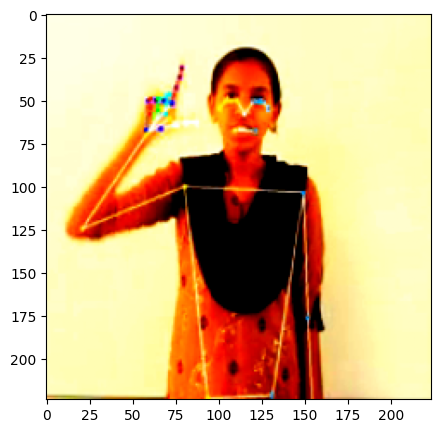

In [ ]:
plt.imshow(inputs['pixel_values'][0,21].cpu().permute(1, 2, 0))

In [ ]:
print(inputs['pixel_values'].min())
print(inputs['pixel_values'].max())

tensor(-0.5765)
tensor(0.6392)


In [ ]:
val_ds = dataset_obj.create_dataset(val_path[:2], val_label[:2], training=False)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)
del val_ds
torch.cuda.empty_cache()
gc.collect()

  0%|          | 0/2 [00:00<?, ?it/s]

<ipython-input-66-c911775b4d36>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.uint8)


18

In [ ]:
# Example usage
inputs = next(iter(val_dl))
print(inputs['pixel_values'].shape, inputs['labels'].shape)

torch.Size([1, 32, 3, 224, 224]) torch.Size([1, 35])


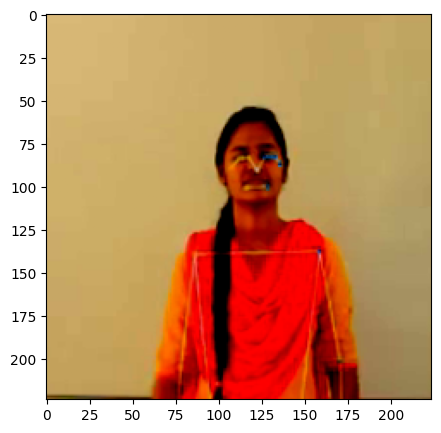

In [ ]:
plt.imshow(inputs['pixel_values'][0,7].cpu().permute(1, 2, 0))

In [ ]:
print(inputs['pixel_values'].min())
print(inputs['pixel_values'].max())

tensor(-0.9843)
tensor(1.)


# Creating DataLoader

In [ ]:
#torch.cuda.empty_cache()

In [47]:
train_ds = dataset_obj.create_dataset(train_path, train_label, training=True)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
del train_ds
torch.cuda.empty_cache()
gc.collect()

  0%|          | 0/745 [00:00<?, ?it/s]

17

In [48]:
inputs = next(iter(train_dl))
print(inputs['pixel_values'].shape, inputs['labels'].shape)

torch.Size([2, 32, 3, 224, 224]) torch.Size([2])


In [49]:
val_ds = dataset_obj.create_dataset(val_path, val_label, training=False)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)
del val_ds
torch.cuda.empty_cache()
gc.collect()

  0%|          | 0/234 [00:00<?, ?it/s]

17

In [50]:
inputs = next(iter(val_dl))
print(inputs['pixel_values'].shape, inputs['labels'].shape)

torch.Size([2, 32, 3, 224, 224]) torch.Size([2])


# Model Training

In [60]:
torch.cuda.empty_cache()

In [61]:
hyperparameters = {
    "learning_rate": 0.0001,
    "num_epochs": 1000, # set to very high number
    "seed": 42,
    "patience": 10, # early stopping
    "output_dir_pt": f"{gdrive_path}/Models/vivit_pytorch_GPU_6.pt",
    "output_dir_transformer": f"{gdrive_path}/Models/vivit_pytorch_transformer_GPU_6",
    "dropout_rate": 0.3,
    #"image_size":CLIP_SIZE,
    #"num_frames":CLIP_LENGTH,
    "num_attention_heads": 2,
    "num_hidden_layers": 2,
    #"intermediate_size": 3072//32,# 3072 used in the original model
    #"hidden_size": 768//2, # ViT uses 12 heads → 768 / 12 = 64 per head
    "tubelet_size":[2, 16, 16], # Original (2, 16, 16)
}

In [ ]:
## Instantiate the model, chnage the final classification layer, let Accelerate handle the device placement.
#config_test = VivitConfig.from_pretrained(
#    MODEL_TRANSFORMER,
#    id2label=idx_to_label,
#    label2id=label_to_idx,
#    num_labels=len(classes),
#    hidden_dropout_prob=hyperparameters['dropout_rate'],
#    attention_probs_dropout_prob=hyperparameters['dropout_rate'],
#    tubelet_size=hyperparameters['tubelet_size'],
#    num_attention_heads=hyperparameters['num_attention_heads'],
#    hidden_size=hyperparameters['hidden_size'],
#    num_hidden_layers=hyperparameters['num_hidden_layers'],
#    intermediate_size=hyperparameters['intermediate_size'],
#    return_dict=True
#    )
#transformer_vivit_test = VivitForVideoClassification.from_pretrained(MODEL_TRANSFORMER, config=config_test, ignore_mismatched_sizes=True)

In [ ]:
#transformer_vivit_test.config

VivitConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "google/vivit-b-16x2",
  "architectures": [
    "VivitForVideoClassification"
  ],
  "attention_probs_dropout_prob": 0.3,
  "hidden_act": "gelu_fast",
  "hidden_dropout_prob": 0.3,
  "hidden_size": 48,
  "id2label": {
    "0": "big",
    "1": "cold",
    "2": "dry",
    "3": "happy",
    "4": "healthy",
    "5": "old",
    "6": "quiet",
    "7": "short",
    "8": "sick",
    "9": "slow"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 192,
  "label2id": {
    "big": 0,
    "cold": 1,
    "dry": 2,
    "happy": 3,
    "healthy": 4,
    "old": 5,
    "quiet": 6,
    "short": 7,
    "sick": 8,
    "slow": 9
  },
  "layer_norm_eps": 1e-06,
  "model_type": "vivit",
  "num_attention_heads": 2,
  "num_channels": 3,
  "num_frames": 32,
  "num_hidden_layers": 2,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.48.3",
  "tubelet_size": [
    32,
    64,
    64
  ]
}

In [ ]:
#transformer_vivit_test

VivitForVideoClassification(
  (vivit): VivitModel(
    (embeddings): VivitEmbeddings(
      (patch_embeddings): VivitTubeletEmbeddings(
        (projection): Conv3d(3, 48, kernel_size=(32, 64, 64), stride=(32, 64, 64))
      )
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (encoder): VivitEncoder(
      (layer): ModuleList(
        (0-1): 2 x VivitLayer(
          (attention): VivitSdpaAttention(
            (attention): VivitSdpaSelfAttention(
              (query): Linear(in_features=48, out_features=48, bias=True)
              (key): Linear(in_features=48, out_features=48, bias=True)
              (value): Linear(in_features=48, out_features=48, bias=True)
              (dropout): Dropout(p=0.3, inplace=False)
            )
            (output): VivitSelfOutput(
              (dense): Linear(in_features=48, out_features=48, bias=True)
              (dropout): Dropout(p=0.3, inplace=False)
            )
          )
          (intermediate): VivitIntermediate(
            

In [ ]:
#for param in transformer_vivit.vivit.parameters():
#    param.requires_grad = False
#for layer in transformer_vivit.vivit.encoder.layer[8:]:  # Opening last 4 transformer blocks
#    for param in layer.parameters():
#        param.requires_grad = True
#for param in transformer_vivit.vivit.layernorm.parameters():
#    param.requires_grad = True

In [ ]:
#for param in transformer_vivit.vivit.embeddings.parameters():
#    param.requires_grad = False

In [ ]:
#for name, param in transformer_vivit.named_parameters():
#    print(f"{name}: {'Frozen' if not param.requires_grad else 'Trainable'}")

In [ ]:
#trainable_params = sum(p.numel() for p in transformer_vivit_test.parameters() if p.requires_grad)
#frozen_params = sum(p.numel() for p in transformer_vivit_test.parameters() if not p.requires_grad)
#
#print(f"Trainable Parameters: {trainable_params}")
#print(f"Frozen Parameters: {frozen_params}")

Trainable Parameters: 18932074
Frozen Parameters: 0


In [58]:
def training_function():
    # Initialize accelerator with fp16 if available
    accelerator = Accelerator(mixed_precision="fp16")

    # Set logging verbosity for main process only
    if accelerator.is_main_process:
        datasets.utils.logging.set_verbosity_warning()
        transformers.utils.logging.set_verbosity_info()
    else:
        datasets.utils.logging.set_verbosity_error()
        transformers.utils.logging.set_verbosity_error()

    # Instantiate the model and config
    config = VivitConfig.from_pretrained(
        MODEL_TRANSFORMER,
        id2label=idx_to_label,
        label2id=label_to_idx,
        num_labels=len(classes),

        #hidden_dropout_prob=hyperparameters['dropout_rate'],
        #attention_probs_dropout_prob=hyperparameters['dropout_rate'],

        num_attention_heads=hyperparameters['num_attention_heads'], #12
        num_hidden_layers=hyperparameters['num_hidden_layers'], #12

        #hidden_size=hyperparameters['hidden_size'], #768
        #intermediate_size=hyperparameters['intermediate_size'], #3072

        #tubelet_size=hyperparameters['tubelet_size'], #(2, 16, 16)
        return_dict=True
    )
    transformer_vivit = VivitForVideoClassification.from_pretrained(
        MODEL_TRANSFORMER,
        config=config,
        ignore_mismatched_sizes=True
    )

    # Freeze all parameters first, then unfreeze the last 4 transformer blocks and layernorm
    #for param in transformer_vivit.vivit.parameters():
    #    param.requires_grad = True
    #for layer in transformer_vivit.vivit.encoder.layer[2:]:  # Unfreeze last 4 transformer blocks
    #    for param in layer.parameters():
    #        param.requires_grad = True
    #for param in transformer_vivit.vivit.layernorm.parameters():
    #    param.requires_grad = True

    # Final Classification Layer
    #transformer_vivit.classifier = torch.nn.Linear(transformer_vivit.config.hidden_size, len(classes))

    # Set seed
    set_seed(hyperparameters["seed"])

    # Enable gradient checkpointing to save memory
    transformer_vivit.gradient_checkpointing_enable()

    # Final Classification Layer
    #transformer_vivit.classifier = torch.nn.Linear(transformer_vivit.config.hidden_size, len(classes))

    # Loss function
    criterion = torch.nn.CrossEntropyLoss()

    # Instantiate optimizer; optionally, you can filter parameters:
    # trainable_params = filter(lambda p: p.requires_grad, transformer_vivit.parameters())
    optimizer = AdamW(transformer_vivit.parameters(), lr=hyperparameters["learning_rate"])

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True, min_lr=0.00001
    )

    # Prepare objects with the accelerator
    accelerated_model, accelerated_optimizer, accelerated_criterion, accelerated_train_dl, accelerated_val_dl = accelerator.prepare(
        transformer_vivit, optimizer, criterion, train_dl, val_dl
    )

    # Training loop variables
    epochs_no_improve = 0
    min_val_loss = float("inf")

    for epoch in range(hyperparameters["num_epochs"]):
        progress_bar = tqdm(range(len(accelerated_train_dl)), disable=not accelerator.is_main_process)
        progress_bar.set_description(f"Epoch: {epoch}")
        accelerated_model.train()
        training_loss = []

        for batch in accelerated_train_dl:
            # Forward pass
            outputs = accelerated_model(**batch)
            #train_logits = outputs.logits
            #train_labels = batch['labels']
            #train_loss = accelerated_criterion(train_logits, train_labels)
            train_loss = outputs.loss

            # Backward pass
            accelerator.backward(train_loss)

            # Optimizer step and gradient reset
            accelerated_optimizer.step()
            accelerated_optimizer.zero_grad()

            # Gather loss from all processes
            training_loss.append(accelerator.gather(train_loss[None]))
            progress_bar.set_postfix({'loss': train_loss.detach().cpu().numpy()})
            progress_bar.update(1)

        # Compute average training loss
        training_loss_final = torch.stack(training_loss).sum().item() / len(training_loss)
        accelerator.print(f"epoch {epoch}: learning rate: {scheduler.get_last_lr()}")
        accelerator.print(f"epoch {epoch}: training loss: {training_loss_final}")

        # Evaluation on validation set
        accelerated_model.eval()
        validation_loss = []
        for batch in accelerated_val_dl:
            with torch.no_grad():
                outputs = accelerated_model(**batch)
            #val_logits = outputs.logits
            #val_labels = batch['labels']
            #val_loss = accelerated_criterion(val_logits, val_labels)
            val_loss = outputs.loss
            validation_loss.append(accelerator.gather(val_loss[None]))

        validation_loss_final = torch.stack(validation_loss).sum().item() / len(validation_loss)
        accelerator.print(f"epoch {epoch}: validation loss: {validation_loss_final}")

        # Update the learning rate scheduler
        scheduler.step(validation_loss_final)

        # Early stopping and model saving
        if validation_loss_final < min_val_loss:
            epochs_no_improve = 0
            min_val_loss = validation_loss_final
            # Save the entire model
            torch.save(accelerated_model, hyperparameters['output_dir_pt'])
            accelerated_model.save_pretrained(hyperparameters['output_dir_transformer'])
        else:
            epochs_no_improve += 1
            if epochs_no_improve == hyperparameters["patience"]:
                accelerator.print("Early stopping!")
                break

In [62]:
# Run the trainer function
training_function()

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--vivit-b-16x2/snapshots/fc341053d36b42d446b3ffccdbd52452712a23f3/config.json
Model config VivitConfig {
  "architectures": [
    "VivitForVideoClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "hidden_act": "gelu_fast",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "afternoon",
    "1": "animal",
    "2": "bad",
    "3": "beautiful",
    "4": "big",
    "5": "bird",
    "6": "blind",
    "7": "cat",
    "8": "cheap",
    "9": "clothing",
    "10": "cold",
    "11": "cow",
    "12": "curved",
    "13": "deaf",
    "14": "dog",
    "15": "dress",
    "16": "dry",
    "17": "evening",
    "18": "expensive",
    "19": "famous",
    "20": "fast",
    "21": "female",
    "22": "fish",
    "23": "flat",
    "24": "friday",
    "25": "good",
    "26": "happy",
    "27": "hat",
    "28": "healthy",
    "29": "horse",
    "30": "hot",
    "31": "hour",
    "

  0%|          | 0/373 [00:00<?, ?it/s]

Safetensors PR exists


epoch 0: learning rate: [0.0001]
epoch 0: training loss: 4.458141337131368
epoch 0: validation loss: 4.212456597222222


Configuration saved in /content/drive/MyDrive/Kaggle/SignLanguage/Models/vivit_pytorch_transformer_GPU_6/config.json
Model weights saved in /content/drive/MyDrive/Kaggle/SignLanguage/Models/vivit_pytorch_transformer_GPU_6/model.safetensors


  0%|          | 0/373 [00:00<?, ?it/s]

epoch 1: learning rate: [0.0001]
epoch 1: training loss: 4.0672977232741285
epoch 1: validation loss: 3.4164830395299144


Configuration saved in /content/drive/MyDrive/Kaggle/SignLanguage/Models/vivit_pytorch_transformer_GPU_6/config.json
Model weights saved in /content/drive/MyDrive/Kaggle/SignLanguage/Models/vivit_pytorch_transformer_GPU_6/model.safetensors


  0%|          | 0/373 [00:00<?, ?it/s]

epoch 2: learning rate: [0.0001]
epoch 2: training loss: 2.9563812992208445
epoch 2: validation loss: 2.0760936247996793


Configuration saved in /content/drive/MyDrive/Kaggle/SignLanguage/Models/vivit_pytorch_transformer_GPU_6/config.json
Model weights saved in /content/drive/MyDrive/Kaggle/SignLanguage/Models/vivit_pytorch_transformer_GPU_6/model.safetensors


  0%|          | 0/373 [00:00<?, ?it/s]

epoch 3: learning rate: [0.0001]
epoch 3: training loss: 1.4769904006262566
epoch 3: validation loss: 1.3658041668753338


Configuration saved in /content/drive/MyDrive/Kaggle/SignLanguage/Models/vivit_pytorch_transformer_GPU_6/config.json
Model weights saved in /content/drive/MyDrive/Kaggle/SignLanguage/Models/vivit_pytorch_transformer_GPU_6/model.safetensors


  0%|          | 0/373 [00:00<?, ?it/s]

epoch 4: learning rate: [0.0001]
epoch 4: training loss: 0.656269635975201
epoch 4: validation loss: 0.9907386975410657


Configuration saved in /content/drive/MyDrive/Kaggle/SignLanguage/Models/vivit_pytorch_transformer_GPU_6/config.json
Model weights saved in /content/drive/MyDrive/Kaggle/SignLanguage/Models/vivit_pytorch_transformer_GPU_6/model.safetensors


  0%|          | 0/373 [00:00<?, ?it/s]

epoch 5: learning rate: [0.0001]
epoch 5: training loss: 0.20629322369041136
epoch 5: validation loss: 0.7567600348056891


Configuration saved in /content/drive/MyDrive/Kaggle/SignLanguage/Models/vivit_pytorch_transformer_GPU_6/config.json
Model weights saved in /content/drive/MyDrive/Kaggle/SignLanguage/Models/vivit_pytorch_transformer_GPU_6/model.safetensors


  0%|          | 0/373 [00:00<?, ?it/s]

epoch 6: learning rate: [0.0001]
epoch 6: training loss: 0.053066130937264366
epoch 6: validation loss: 0.5803297646025307


Configuration saved in /content/drive/MyDrive/Kaggle/SignLanguage/Models/vivit_pytorch_transformer_GPU_6/config.json
Model weights saved in /content/drive/MyDrive/Kaggle/SignLanguage/Models/vivit_pytorch_transformer_GPU_6/model.safetensors


  0%|          | 0/373 [00:00<?, ?it/s]

epoch 7: learning rate: [0.0001]
epoch 7: training loss: 0.015605701518122695
epoch 7: validation loss: 0.5370068672375802


Configuration saved in /content/drive/MyDrive/Kaggle/SignLanguage/Models/vivit_pytorch_transformer_GPU_6/config.json
Model weights saved in /content/drive/MyDrive/Kaggle/SignLanguage/Models/vivit_pytorch_transformer_GPU_6/model.safetensors


  0%|          | 0/373 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
'''
Epoch: 0: 100%
 373/373 [09:44<00:00,  1.22it/s, loss=4.0703125]
Safetensors PR exists
epoch 0: learning rate: [0.0001]
epoch 0: training loss: 4.41235547922252
epoch 0: validation loss: 4.2978515625
Configuration saved in /content/drive/MyDrive/Kaggle/SignLanguage/Models/vivit_pytorch_transformer_GPU_6/config.json
Model weights saved in /content/drive/MyDrive/Kaggle/SignLanguage/Models/vivit_pytorch_transformer_GPU_6/model.safetensors
Epoch: 1: 100%
 373/373 [16:53<00:00,  1.22it/s, loss=4.5664062]
epoch 1: learning rate: [0.0001]
epoch 1: training loss: 4.309732636561662
epoch 1: validation loss: 4.215870392628205
Configuration saved in /content/drive/MyDrive/Kaggle/SignLanguage/Models/vivit_pytorch_transformer_GPU_6/config.json
Model weights saved in /content/drive/MyDrive/Kaggle/SignLanguage/Models/vivit_pytorch_transformer_GPU_6/model.safetensors
Epoch: 2: 100%
 373/373 [10:38<00:00,  1.22it/s, loss=4.0078125]
epoch 2: learning rate: [0.0001]
epoch 2: training loss: 4.164133189510724
epoch 2: validation loss: 3.9393362713675213
Configuration saved in /content/drive/MyDrive/Kaggle/SignLanguage/Models/vivit_pytorch_transformer_GPU_6/config.json
Model weights saved in /content/drive/MyDrive/Kaggle/SignLanguage/Models/vivit_pytorch_transformer_GPU_6/model.safetensors
Epoch: 3: 100%
 373/373 [17:44<00:00,  1.23it/s, loss=3.7324219]
epoch 3: learning rate: [0.0001]
epoch 3: training loss: 3.9563950444034854
epoch 3: validation loss: 3.7939286191239314
Configuration saved in /content/drive/MyDrive/Kaggle/SignLanguage/Models/vivit_pytorch_transformer_GPU_6/config.json
Model weights saved in /content/drive/MyDrive/Kaggle/SignLanguage/Models/vivit_pytorch_transformer_GPU_6/model.safetensors
Epoch: 4: 100%
 373/373 [11:29<00:00,  1.23it/s, loss=3.890625]
epoch 4: learning rate: [0.0001]
epoch 4: training loss: 3.8382938170241285
epoch 4: validation loss: 3.6759481837606836
Configuration saved in /content/drive/MyDrive/Kaggle/SignLanguage/Models/vivit_pytorch_transformer_GPU_6/config.json
Model weights saved in /content/drive/MyDrive/Kaggle/SignLanguage/Models/vivit_pytorch_transformer_GPU_6/model.safetensors
Epoch: 5: 100%
 373/373 [19:05<00:00,  1.23it/s, loss=4.8945312]
epoch 5: learning rate: [0.0001]
epoch 5: training loss: 3.704237705261394
epoch 5: validation loss: 3.6811231303418803
Epoch: 6: 100%
 373/373 [12:53<00:00,  1.22it/s, loss=3.0332031]
epoch 6: learning rate: [0.0001]
epoch 6: training loss: 3.5905637357573728
epoch 6: validation loss: 3.525206997863248
Configuration saved in /content/drive/MyDrive/Kaggle/SignLanguage/Models/vivit_pytorch_transformer_GPU_6/config.json
Model weights saved in /content/drive/MyDrive/Kaggle/SignLanguage/Models/vivit_pytorch_transformer_GPU_6/model.safetensors
Epoch: 7: 100%
 373/373 [06:37<00:00,  1.22it/s, loss=3.5039062]
epoch 7: learning rate: [0.0001]
epoch 7: training loss: 3.2853166104641423
epoch 7: validation loss: 3.1113030849358974
Configuration saved in /content/drive/MyDrive/Kaggle/SignLanguage/Models/vivit_pytorch_transformer_GPU_6/config.json
Model weights saved in /content/drive/MyDrive/Kaggle/SignLanguage/Models/vivit_pytorch_transformer_GPU_6/model.safetensors
Epoch: 8: 100%
 373/373 [13:09<00:00,  1.20it/s, loss=2.7421875]
epoch 8: learning rate: [0.0001]
epoch 8: training loss: 2.7781579884383376
epoch 8: validation loss: 3.08087158203125
Configuration saved in /content/drive/MyDrive/Kaggle/SignLanguage/Models/vivit_pytorch_transformer_GPU_6/config.json
Model weights saved in /content/drive/MyDrive/Kaggle/SignLanguage/Models/vivit_pytorch_transformer_GPU_6/model.safetensors
Epoch: 9: 100%
 373/373 [06:49<00:00,  1.20it/s, loss=2.3867188]
epoch 9: learning rate: [0.0001]
epoch 9: training loss: 2.2558420298885724
epoch 9: validation loss: 2.3890537359775643
Configuration saved in /content/drive/MyDrive/Kaggle/SignLanguage/Models/vivit_pytorch_transformer_GPU_6/config.json
Model weights saved in /content/drive/MyDrive/Kaggle/SignLanguage/Models/vivit_pytorch_transformer_GPU_6/model.safetensors
Epoch: 10: 100%
 373/373 [12:55<00:00,  1.20it/s, loss=1.3027344]
epoch 10: learning rate: [0.0001]
epoch 10: training loss: 1.532751170304122
epoch 10: validation loss: 2.2206175714476495
Configuration saved in /content/drive/MyDrive/Kaggle/SignLanguage/Models/vivit_pytorch_transformer_GPU_6/config.json
Model weights saved in /content/drive/MyDrive/Kaggle/SignLanguage/Models/vivit_pytorch_transformer_GPU_6/model.safetensors
Epoch: 11: 100%
 373/373 [06:36<00:00,  1.22it/s, loss=0.057922363]
epoch 11: learning rate: [0.0001]
epoch 11: training loss: 0.7626350955093834
epoch 11: validation loss: 2.0823502499833064
Configuration saved in /content/drive/MyDrive/Kaggle/SignLanguage/Models/vivit_pytorch_transformer_GPU_6/config.json
Model weights saved in /content/drive/MyDrive/Kaggle/SignLanguage/Models/vivit_pytorch_transformer_GPU_6/model.safetensors
Epoch: 12: 100%
 373/373 [05:54<00:00,  1.21it/s, loss=0.19714355]
epoch 12: learning rate: [0.0001]
epoch 12: training loss: 0.3247156219891505
epoch 12: validation loss: 1.9132280920305822
Configuration saved in /content/drive/MyDrive/Kaggle/SignLanguage/Models/vivit_pytorch_transformer_GPU_6/config.json
Model weights saved in /content/drive/MyDrive/Kaggle/SignLanguage/Models/vivit_pytorch_transformer_GPU_6/model.safetensors
'''

In [ ]:
'''
epoch 4: learning rate: [0.0001]
epoch 4: training loss: 0.6882950996685969
epoch 4: validation loss: 0.9578143467764473
Saveing the model
Epoch: 5: 100%
 95/95 [25:09<00:00,  3.08s/it, loss=0.214]
epoch 5: learning rate: [0.0001]
epoch 5: training loss: 0.334061036224624
epoch 5: validation loss: 0.6734721306142293
Saveing the model
Epoch: 6: 100%
 95/95 [19:56<00:00,  3.09s/it, loss=0.0452]
epoch 6: learning rate: [0.0001]
epoch 6: training loss: 0.1617632053964036
epoch 6: validation loss: 0.7600871691855394
Epoch: 7: 100%
 95/95 [14:43<00:00,  3.09s/it, loss=0.0333]
epoch 7: learning rate: [0.0001]
epoch 7: training loss: 0.11765114350955148
epoch 7: validation loss: 0.6403691204387643
Saveing the model
Epoch: 8: 100%
 95/95 [09:29<00:00,  3.09s/it, loss=0.0172]
epoch 8: learning rate: [0.0001]
epoch 8: training loss: 0.043264231083326436
epoch 8: validation loss: 0.5814998383316883
Saveing the model
Epoch: 9: 100%
 95/95 [04:53<00:00,  3.09s/it, loss=0.0133]
epoch 9: learning rate: [0.0001]
epoch 9: training loss: 0.023389429934813005
epoch 9: validation loss: 0.5116678952042194

'''

# Load model

In [67]:
model_pretrained = VivitForVideoClassification.from_pretrained(hyperparameters['output_dir_transformer']).to(device)
model_pretrained.eval()
print("Entire model loaded successfully!")

loading configuration file /content/drive/MyDrive/Kaggle/SignLanguage/Models/vivit_pytorch_transformer_GPU_6/config.json
Model config VivitConfig {
  "_name_or_path": "google/vivit-b-16x2",
  "architectures": [
    "VivitForVideoClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "hidden_act": "gelu_fast",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "afternoon",
    "1": "animal",
    "2": "bad",
    "3": "beautiful",
    "4": "big",
    "5": "bird",
    "6": "blind",
    "7": "cat",
    "8": "cheap",
    "9": "clothing",
    "10": "cold",
    "11": "cow",
    "12": "curved",
    "13": "deaf",
    "14": "dog",
    "15": "dress",
    "16": "dry",
    "17": "evening",
    "18": "expensive",
    "19": "famous",
    "20": "fast",
    "21": "female",
    "22": "fish",
    "23": "flat",
    "24": "friday",
    "25": "good",
    "26": "happy",
    "27": "hat",
    "28": "healthy",
    "29": "horse",
    "30": "hot",
    "31": "hour",
    "32": "light

Entire model loaded successfully!


In [ ]:
#model_pretrained = torch.load(hyperparameters['output_dir'], map_location=torch.device('cpu'))
#model_pretrained.eval()
#print("Entire model loaded successfully!")

# Model Testing - TEST Data

In [63]:
class CustomDatasetTest(Dataset):
    def __init__(self, pixel_values, labels):
        self.pixel_values = pixel_values.to('cpu')
        self.labels = labels.to('cpu')

    def __len__(self):
        return len(self.pixel_values)

    def __getitem__(self, idx):
        item = {
            'pixel_values': self.pixel_values[idx],
            'labels':self.labels[idx]
        }
        return item

In [64]:
class CreateDatasetTest():
    def __init__(self, clip_length, image_processor):
        super().__init__()
        self.clip_length = clip_length
        self.image_processor = image_processor

    def create_dataset(self, video_paths, labels):
        pixel_values = []

        for path in tqdm(video_paths):
            # Read and process Videos
            vr = VideoReader(path)
            video = vr.get_batch(list(range(len(vr))))
            video = video[:self.clip_length]

            # Data Preperation for ML Model without Augmentation
            video = transforms.v2.functional.to_dtype(video.permute(0, 3, 1, 2), torch.uint8, scale=False)
            video = self.image_processor(list(video), return_tensors='pt', input_data_format='channels_first')

            #print('Stage 4',video.shape)
            pixel_values.append(video['pixel_values'].squeeze(0))

            # Force garbage collection
            del vr, video
            gc.collect()

        pixel_values = torch.stack(pixel_values)
        labels = torch.tensor(labels, dtype=torch.uint8)

        return CustomDatasetTest(pixel_values=pixel_values,
                                 labels=labels)

In [65]:
dataset_test_obj = CreateDatasetTest(CLIP_LENGTH, image_processor)

In [66]:
test_ds = dataset_test_obj.create_dataset(test_path, test_label)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)
del test_ds
gc.collect()

  0%|          | 0/187 [00:00<?, ?it/s]

17

In [ ]:
#torch.cuda.empty_cache()

In [68]:
# Now we train the model
def testing_function(model_pretrained):
    # Initialize accelerator
    accelerator = Accelerator()#(fp16=True)

    # To have only one message (and not 8) per logs of Transformers or Datasets, we set the logging verbosity
    # to INFO for the main process only.
    if accelerator.is_main_process:
        datasets.utils.logging.set_verbosity_warning()
        transformers.utils.logging.set_verbosity_info()
    else:
        datasets.utils.logging.set_verbosity_error()
        transformers.utils.logging.set_verbosity_error()

    # The seed need to be set before we instantiate the model, as it will determine the random head.
    set_seed(hyperparameters["seed"])

    # Load the model
    #model_pretrained = VivitForVideoClassification.from_pretrained(hyperparameters['output_dir_transformer'])

    # There is no specific order to remember, we just need to unpack the objects in the same order we gave them to the
    # prepare method.
    accelerated_model, acclerated_test_dl = accelerator.prepare(model_pretrained, test_dl)

    # Build the training loop
    epochs_no_improve = 0

    # Evaluate at the end of the epoch (distributed evaluation as we have 8 TPU cores)
    accelerated_model.eval()

    test_labels = []
    test_preds = []

    for batch in tqdm(acclerated_test_dl):
        with torch.no_grad():
            outputs = accelerated_model(**batch)

        test_logits = outputs.logits
        test_softmax = torch.nn.functional.softmax(test_logits, dim=-1)
        test_pred = test_softmax.argmax(-1)
        test_preds.append(test_pred)

        test_label = batch['labels']
        test_labels.append(test_label)

        #test_preds = torch.cat(test_pred)
        #test_labels = torch.cat(test_label)
    return test_labels, test_preds


In [69]:
actual_label, predicted_test_label = testing_function(model_pretrained)

  0%|          | 0/94 [00:00<?, ?it/s]

In [70]:
actual_labels = torch.cat(actual_label, 0).to('cpu')
predicted_test_labels = torch.cat(predicted_test_label,0).to('cpu')

In [71]:
predicted_test_labels.numpy()

array([56, 20, 42,  1, 57,  3, 36, 17, 66, 70, 10, 16, 45, 16, 65, 60, 38,
       16, 29, 22, 26, 39, 53, 51, 74, 48, 51, 75, 74, 69, 64, 47, 58, 20,
       16, 23, 72, 53, 11, 24, 47,  7, 71, 28, 57, 22, 57, 49, 35, 30, 45,
       54, 29, 55, 27, 44,  2, 36,  5, 17, 58,  6, 45, 60,  9, 53, 14, 26,
       14, 74, 15, 58,  0,  1, 29, 25,  7, 47, 73, 75, 39,  7, 24, 42, 35,
       10, 40, 54, 35, 33, 57, 62, 46, 45, 56, 43,  5, 68, 61, 51, 34,  1,
       72, 44, 60, 75, 10, 37, 68, 31, 22, 12, 57, 46,  2, 13,  4, 51, 71,
       51, 22, 42, 51, 14, 63, 11, 20, 27,  4, 21, 50, 66, 49, 61, 60, 28,
       41,  8,  9, 33, 26, 27, 28, 38, 45, 37, 41, 39,  5, 46, 19, 41, 65,
        4, 32,  0, 70, 35, 63,  9, 63, 71, 65, 56,  9, 11,  2, 71, 54, 25,
       67, 61, 42, 69, 38, 18, 44,  4, 68, 20, 73, 25, 41, 39, 68, 33, 59])

In [72]:
actual_labels

tensor([56, 20, 42,  1, 57,  3, 36, 17, 66, 70, 10, 30, 45, 16, 65, 60, 38, 16,
        29, 40, 26, 59, 53, 52, 62, 48, 51, 75, 74, 69, 64, 47, 58,  2, 16, 23,
        72, 53, 11, 24, 47,  7, 71, 28, 57, 22, 57, 49, 35, 30, 55, 54, 40, 55,
        27, 44,  2, 36,  5, 17, 58,  6, 55,  9,  9, 53, 14, 26, 14, 74, 15, 58,
         0,  1, 29, 25,  7, 47, 73, 75, 39,  7, 24, 42, 28, 10, 40, 54, 35, 33,
        53, 62, 46, 45, 56, 43,  5, 61, 61, 51, 34,  1, 72, 44, 60, 75, 10, 37,
        68, 31, 22, 12, 57, 46,  2, 13,  4, 52, 71, 52, 22, 42, 51, 14, 31, 11,
        20, 27,  4, 21, 50, 66, 49, 61, 60, 28, 41,  8, 15, 33, 26, 27, 30, 29,
        45, 37, 41, 43,  5, 46, 19, 72, 65,  4, 32,  0, 70, 35, 63, 15, 63, 71,
        64, 56,  9, 11, 25, 71, 54,  2, 67, 61, 42, 69, 38, 18, 44,  4, 68, 20,
        73, 25, 41, 39, 68, 33, 59], dtype=torch.uint8)

In [73]:
print(classification_report(actual_labels.numpy(),
                            predicted_test_labels.numpy(),
                            ))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         3
           2       0.67      0.50      0.57         4
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         1
           9       0.50      0.67      0.57         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         3
          15       1.00      0.33      0.50         3
          16       0.75      1.00      0.86         3
          17       1.00    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Create MP Objects

In [ ]:
hand_model_path = '/content/drive/MyDrive/Kaggle/SignLanguage/hand_landmarker.task'
pose_model_path = '/content/drive/MyDrive/Kaggle/SignLanguage/pose_landmarker.task'

In [ ]:
BaseOptions = mp.tasks.BaseOptions
HandLandmarker = mp.tasks.vision.HandLandmarker
HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions
PoseLandmarker = mp.tasks.vision.PoseLandmarker
PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
#FaceLandmarker = mp.tasks.vision.FaceLandmarker
#FaceLandmarkerOptions = mp.tasks.vision.FaceLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

# Create a hand landmarker instance with the video mode:
options_hand = HandLandmarkerOptions(
    base_options=BaseOptions(model_asset_path = hand_model_path),
    running_mode=VisionRunningMode.VIDEO)

# Create a pose landmarker instance with the video mode:
options_pose = PoseLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=pose_model_path),
    running_mode=VisionRunningMode.VIDEO)

## Create a face landmarker instance with the video mode:
#options_face = FaceLandmarkerOptions(
#    base_options=BaseOptions(model_asset_path=face_model_path),
#    running_mode=VisionRunningMode.VIDEO)

#detector_face = vision.FaceLandmarker.create_from_options(options_face)
detector_hand = vision.HandLandmarker.create_from_options(options_hand)
detector_pose = vision.PoseLandmarker.create_from_options(options_pose)

In [ ]:
holistic = mp_holistic.Holistic(
    static_image_mode=False,
    model_complexity=1,
    smooth_landmarks=True,
    enable_segmentation=False,
    refine_face_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
    )

# Model testing - PROD Data

In [ ]:
class CustomDatasetProd(Dataset):
    def __init__(self, pixel_values):
        self.pixel_values = pixel_values.to('cpu')

    def __len__(self):
        return len(self.pixel_values)

    def __getitem__(self, idx):
        item = {
            'pixel_values': self.pixel_values[idx]
        }
        return item

In [ ]:
class CreateDatasetProd():
    def __init__(self
                , clip_len
                , clip_size
                , frame_step
                ):
        super().__init__()
        self.clip_len = clip_len
        self.clip_size = clip_size
        self.frame_step = frame_step

        # Define a sample transformation pipeline
        self.transform_prod = transforms.v2.Compose([
                                    transforms.v2.ToImage(),
                                    transforms.v2.Resize((self.clip_size, self.clip_size)),
                                    transforms.v2.ToDtype(torch.float32, scale=True)
                                ])

    def read_video(self, video_path):
        # Read the video and convert to frames
        vr = VideoReader(video_path)
        total_frames = len(vr)

        # Determine frame indices based on total frames
        if total_frames < self.clip_len:
            key_indices = list(range(total_frames))
            for _ in range(self.clip_len - len(key_indices)):
                key_indices.append(key_indices[-1])
        else:
            key_indices = list(range(0, total_frames, max(1, total_frames // self.clip_len)))[:self.clip_len]

        #load frames
        frames = vr.get_batch(key_indices)
        del vr
        # Force garbage collection
        gc.collect()

        return frames

    def add_landmarks(self, video):
        annotated_image = []
        for frame in video:

            #Convert pytorch Tensor to CV2 image
            image = frame.permute(1, 2, 0).numpy() # Convert to (H, W, C) format for mediapipe to work

            results = holistic.process(image)

            mp_drawing.draw_landmarks(
                image,
                results.left_hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                landmark_drawing_spec = mp_drawing_styles.get_default_hand_landmarks_style(),
                connection_drawing_spec = mp_drawing_styles.get_default_hand_connections_style()
                )
            mp_drawing.draw_landmarks(
                image,
                results.right_hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                landmark_drawing_spec = mp_drawing_styles.get_default_hand_landmarks_style(),
                connection_drawing_spec = mp_drawing_styles.get_default_hand_connections_style()
                )
            mp_drawing.draw_landmarks(
                image,
                results.pose_landmarks,
                mp_holistic.POSE_CONNECTIONS,
                landmark_drawing_spec = mp_drawing_styles.get_default_pose_landmarks_style(),
                #connection_drawing_spec = None
                )

            annotated_image.append(torch.from_numpy(image))

            del image, results
            # Force garbage collection
            gc.collect()

        return torch.stack(annotated_image)

    def create_dataset(self, video_paths):
        pixel_values = []
        for path in tqdm(video_paths):
            #print('Video', path)
            # Read and process Videos
            video = self.read_video(path)
            #print('Stage 1',video.shape)
            video = transforms.v2.functional.resize(video.permute(0, 3, 1, 2), size=(self.clip_size*2, self.clip_size*3)) # Auto converts to (F, C, H, W) format
            #print('Stage 2',video.shape)
            video = self.add_landmarks(video)
            #print('Stage 3',video.shape)
            # Data Preperation for ML Model without Augmentation
            video = self.transform_prod(video.permute(0, 3, 1, 2))

            #print('Stage 4',video.shape)
            pixel_values.append(video.to(device))
            del video
            # Force garbage collection
            gc.collect()

        pixel_values = torch.stack(pixel_values).to(device)
        return CustomDatasetProd(pixel_values=pixel_values)


In [ ]:
dataset_prod_obj = CreateDatasetProd(CLIP_LENGTH, CLIP_SIZE, FRAME_STEPS)

In [ ]:
prod_data_dir = f'{gdrive_path}/ProdData'
print(prod_data_dir)

/content/drive/MyDrive/Kaggle/SignLanguage/ProdData


In [ ]:
# Collect all video files
prod_video_path = []

prod_video_file = glob(os.path.join(prod_data_dir, '*.mov'))
print(prod_video_file)
prod_video_path.extend(prod_video_file)

['/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_2_tall.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_3_sad.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_1_ugly.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_4_short.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_5_tall.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_6_sad.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_7_quiet.mov']


In [ ]:
print('input path size:', len(prod_video_path))
print(prod_video_path)

input path size: 7
['/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_2_tall.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_3_sad.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_1_ugly.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_4_short.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_5_tall.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_6_sad.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_7_quiet.mov']


In [ ]:
prod_ds = dataset_prod_obj.create_dataset(prod_video_path)

  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
prod_dl = DataLoader(prod_ds, batch_size=BATCH_SIZE)

In [ ]:
prod_inputs = next(iter(prod_dl))
print(prod_inputs['pixel_values'].shape) #prod_inputs['input_ids'].shape, prod_inputs['attention_mask'].shape, np.array(prod_inputs['labels']).shape

torch.Size([4, 32, 3, 224, 224])


In [ ]:
sample_video = prod_inputs['pixel_values'][0].permute(0, 2, 3, 1)
sample_video.shape

torch.Size([32, 224, 224, 3])

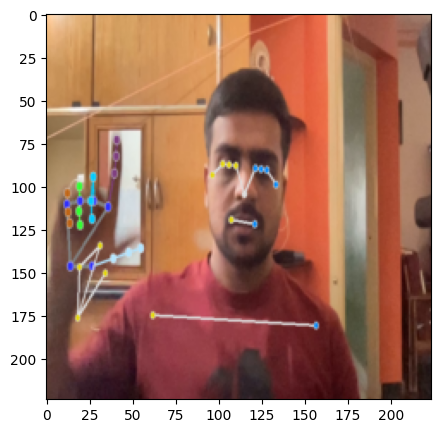

In [ ]:
plt.imshow(sample_video[15])

In [ ]:
# Now we train the model
def prod_function():
    # Initialize accelerator
    accelerator = Accelerator()#(fp16=True)

    # To have only one message (and not 8) per logs of Transformers or Datasets, we set the logging verbosity
    # to INFO for the main process only.
    if accelerator.is_main_process:
        datasets.utils.logging.set_verbosity_warning()
        transformers.utils.logging.set_verbosity_info()
    else:
        datasets.utils.logging.set_verbosity_error()
        transformers.utils.logging.set_verbosity_error()

    # The seed need to be set before we instantiate the model, as it will determine the random head.
    set_seed(hyperparameters["seed"])

    # Load the model
    model_pretrained = VivitForVideoClassification.from_pretrained(hyperparameters['output_dir_transformer'])

    # There is no specific order to remember, we just need to unpack the objects in the same order we gave them to the
    # prepare method.
    accelerated_model, acclerated_prod_dl = accelerator.prepare(model_pretrained, prod_dl)

    # Build the training loop
    epochs_no_improve = 0

    # Evaluate at the end of the epoch (distributed evaluation as we have 8 TPU cores)
    accelerated_model.eval()

    test_preds = []

    for batch in tqdm(acclerated_prod_dl):
        with torch.no_grad():
            outputs = accelerated_model(**batch)

        test_logits = outputs.logits
        test_softmax = torch.nn.functional.softmax(test_logits, dim=-1)
        test_pred = test_softmax.argmax(-1)
        test_preds.append(test_pred)

        #test_preds = torch.cat(test_pred)
        #test_labels = torch.cat(test_label)
    return test_preds


In [ ]:
predicted_label = prod_function()

loading configuration file /content/drive/MyDrive/Kaggle/SignLanguage/vivit_pytorch_transformer_GPU_4/config.json
Model config VivitConfig {
  "_name_or_path": "google/vivit-b-16x2",
  "architectures": [
    "VivitForVideoClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "hidden_act": "gelu_fast",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "bad",
    "1": "beautiful",
    "2": "big",
    "3": "blind",
    "4": "cheap",
    "5": "cold",
    "6": "curved",
    "7": "deaf",
    "8": "dry",
    "9": "famous",
    "10": "fast",
    "11": "female",
    "12": "flat",
    "13": "good",
    "14": "happy",
    "15": "healthy",
    "16": "hot",
    "17": "light",
    "18": "long",
    "19": "loose",
    "20": "loud",
    "21": "narrow",
    "22": "new",
    "23": "old",
    "24": "quiet",
    "25": "sad",
    "26": "short",
    "27": "sick",
    "28": "slow",
    "29": "small",
    "30": "tall",
    "31": "warm",
    "32": "wet",
    "33": "wide",
   

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
predicted_label

[tensor([32,  8, 22, 26], device='cuda:0'),
 tensor([30, 18, 24], device='cuda:0')]

In [ ]:
predicted_prod_labels = torch.cat(predicted_label,0).to('cpu')

In [ ]:
for val in predicted_prod_labels:
  print(idx_to_label[val.item()])

wet
dry
new
short
tall
long
quiet


In [ ]:
for path in prod_video_path:
  print(os.path.basename(path).split('/')[-1])

prod_2_tall.mov
prod_3_sad.mov
prod_1_ugly.mov
prod_4_short.mov
prod_5_tall.mov
prod_6_sad.mov
prod_7_quiet.mov


In [ ]:
idx_to_label

{0: 'bad',
 1: 'beautiful',
 2: 'big',
 3: 'blind',
 4: 'cheap',
 5: 'cold',
 6: 'curved',
 7: 'deaf',
 8: 'dry',
 9: 'famous',
 10: 'fast',
 11: 'female',
 12: 'flat',
 13: 'good',
 14: 'happy',
 15: 'healthy',
 16: 'hot',
 17: 'light',
 18: 'long',
 19: 'loose',
 20: 'loud',
 21: 'narrow',
 22: 'new',
 23: 'old',
 24: 'quiet',
 25: 'sad',
 26: 'short',
 27: 'sick',
 28: 'slow',
 29: 'small',
 30: 'tall',
 31: 'warm',
 32: 'wet',
 33: 'wide',
 34: 'young'}

In [ ]:
#print(classification_report(test_label,predicted_label))